# Python Implementation of Experiments for Thesis

### Import Libraries

In [1]:
#-------------------------Setting the randomness-----------#

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used


import numpy as np
np.random.seed(1) # for reproducability

from tensorflow import set_random_seed
set_random_seed(1) # for reproducability
#------------------------------------------------------#
import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation,Reshape

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Load in training and testing dataset

In [2]:
from numpy import load
train_data = load('data/training_data.npy')
test_data = load('data/testing_data.npy')


 ## Function to choose balancing of training data

In [3]:
def balanced(option):
    if(option=="yes"):
        training_data = np.concatenate((train_data[0:1341],train_data[3875:]),axis=0)
        testing_data = np.concatenate((test_data[0:234],test_data[390:]))
        return training_data,testing_data
    else:
        training_data = train_data
        testing_data = test_data
        return training_data,testing_data


In [4]:
training_data,test_data=balanced("no")
print(training_data.shape)
print(test_data.shape)



(5216, 62501)
(624, 62501)


In [5]:
X_train,X_val,Y_train,Y_val = train_test_split(training_data[0:,1:],training_data[0:,0:1],test_size=0.1,random_state = 1,shuffle=True,stratify=training_data[0:,0:1])

In [6]:
X_train.shape

(4694, 62500)

In [7]:
Y_train[0:10,0:1]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [8]:
#X_train = np.concatenate((X_train,augmented_set[0:,1:]),axis=0)

In [9]:
#Y_train = np.concatenate((Y_train,augmented_set[0:,0:1]),axis=0)

In [10]:
#Y_train.shape

In [11]:
print('All (class distribution):', np.bincount(list(map(float, training_data[0:,0:1]))) / float(len(training_data)) * 100.0)
print('Training (class distribution):', np.bincount(list(map(float,Y_train))) / float(len(Y_train)) * 100.0)
print('Validation (class distribution):', np.bincount(list(map(float,Y_val))) / float(len(Y_val)) * 100.0)

All (class distribution): [25.70935583 74.29064417]
Training (class distribution): [25.71367703 74.28632297]
Validation (class distribution): [25.67049808 74.32950192]


In [12]:
X_test = test_data[0:,1:]
Y_test = test_data[0:,0:1]

In [13]:
y_train_ohe = keras.utils.to_categorical(Y_train, 2)
y_test_ohe = keras.utils.to_categorical(Y_test, 2)
y_val_ohe = keras.utils.to_categorical(Y_val,2)

In [14]:
X_train = X_train.reshape(X_train.shape[0],250,250,1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0],250,250,1)
print(X_test.shape)
X_val = X_val.reshape(X_val.shape[0],250,250,1)
print(X_val.shape)

(4694, 250, 250, 1)
(624, 250, 250, 1)
(522, 250, 250, 1)


## Create 2D CNN 

## 1. Define Sequential Model
## 2. Add 2D CNN with 32 filters,3x3 filters
## 3. Apply Relu
## Repeat x2
## 4. Apply MaxPooling(2,2)
## 5. Send through Fully Connected Layer


In [15]:
def create_model():
    model_CNN = Sequential()
    
    model_CNN.add(Conv2D(32,(3,3),input_shape=(250,250,1)))
    model_CNN.add(Activation('relu')) # Remember, Batch Norm is meant to go before activation. However, for purposes of recreating experriment 1 keep Batch Norm after activation
    
    model_CNN.add(Conv2D(32, (3, 3)))
    model_CNN.add(Activation('relu'))

    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    
    model_CNN.add(Flatten())

    # Fully connected layer
    model_CNN.add(Dense(128))
    model_CNN.add(Activation('relu'))

    #model_CNN.add(Dropout(0.2))
    

    model_CNN.add(Dense(2))
    model_CNN.add(Activation('softmax'))
    
    return model_CNN

# Setup for the experiment below

## 1. Model is ran with the above architeture 
## 2. Trained on Imbalanced Set
## 3. Tested on Imbalanced Set
## 4. Adam Optimiser 0.01

# This is a test to see if running 10 experiments for the same setup of model produces the same results 

In [16]:
history_array = [] ## Used to get callbacks for 10 models
accuracy = [] ## Compute the accuracy from 10 models
model_array = [] # Save 10 models to array to be used for computing the test and returning predictions which are for printing confusion matrix
for i in range(0,5):
    model = create_model()  
    opt = optimizers.Adam(lr=0.01)
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    np.random.seed(1) # for reproducability
    #shuffle= false needs to be used if u want results to be the same every time
    history = model.fit(X_train, y_train_ohe,shuffle=True,batch_size=64,epochs=10,validation_data=(X_val, y_val_ohe))# model
    model_array.append(model)
    history_array.append(history)
    score = model.evaluate(X_test, y_test_ohe)
    accuracy.append(score)

W0422 22:44:46.298394 139907768375104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0422 22:44:46.339965 139907768375104 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0422 22:44:46.636234 139907768375104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:550: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 4694 samples, validate on 522 samples
Epoch 1/10
4694/4694 [==============================] - 9s 2ms/step - loss: 9.0488 - accuracy: 0.7812 - val_loss: 0.3853 - val_accuracy: 0.8563
Epoch 2/10
4694/4694 [==============================] - 7s 2ms/step - loss: 0.2164 - accuracy: 0.9156 - val_loss: 0.1070 - val_accuracy: 0.9598
Epoch 3/10
4694/4694 [==============================] - 7s 2ms/step - loss: 0.1068 - accuracy: 0.9589 - val_loss: 0.1097 - val_accuracy: 0.9598
Epoch 4/10
4694/4694 [==============================] - 8s 2ms/step - loss: 0.0716 - accuracy: 0.9710 - val_loss: 0.0857 - val_accuracy: 0.9732
Epoch 5/10
4694/4694 [==============================] - 8s 2ms/step - loss: 0.0634 - accuracy: 0.9770 - val_loss: 0.1454 - val_accuracy: 0.9425
Epoch 6/10
4694/4694 [==============================] - 8s 2ms/step - loss: 0.0558 - accuracy: 0.9787 - val_loss: 0.0991 - val_accuracy: 0.9636
Epoch 7/10
4694/4694 [==============================] - 8s 2ms/step - loss: 0.0342 - accu

## Print out the accuracys for 5 Models

In [30]:
#print out accuracies for 5 models
print(accuracy)

[[3.9601734856700297, 0.7259615659713745], [3.7774686738682046, 0.7708333134651184], [4.881735115976205, 0.7403846383094788], [3.1666258420324223, 0.7323718070983887], [5.006833717004972, 0.7211538553237915]]


In [21]:
## Lets output the loss and accuracy for the model

# Plot the Model accuracy on the Training and Validation

[0.78121006, 0.91563696, 0.9588837, 0.97102684, 0.9769919, 0.9786962, 0.9880699, 0.98977417, 0.99296975, 0.994248]
[0.8563218116760254, 0.959770143032074, 0.959770143032074, 0.9731800556182861, 0.9425287246704102, 0.9636015295982361, 0.959770143032074, 0.9712643623352051, 0.967432975769043, 0.961685836315155]


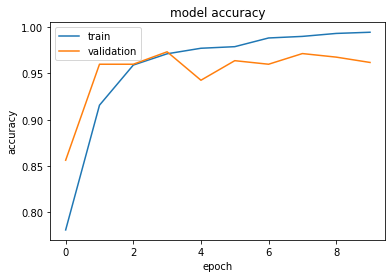

[0.7209203, 0.79590964, 0.8402216, 0.90477204, 0.92884535, 0.9371538, 0.9740094, 0.9838091, 0.9933958, 0.988709]
[0.8065134286880493, 0.8180076479911804, 0.8793103694915771, 0.8946360349655151, 0.8888888955116272, 0.9042145609855652, 0.9214559197425842, 0.931034505367279, 0.8965517282485962, 0.9425287246704102]


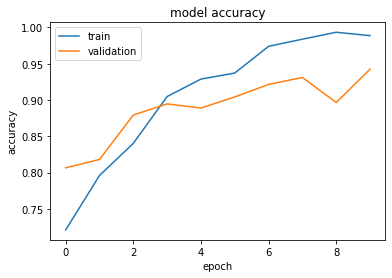

[0.74414146, 0.7716234, 0.83532166, 0.9024286, 0.94418406, 0.9737963, 0.98849595, 0.9931828, 0.98551345, 0.9982957]
[0.8180076479911804, 0.8218390941619873, 0.8505747318267822, 0.8946360349655151, 0.9272030591964722, 0.9137930870056152, 0.9348658919334412, 0.8946360349655151, 0.9291187524795532, 0.946360170841217]


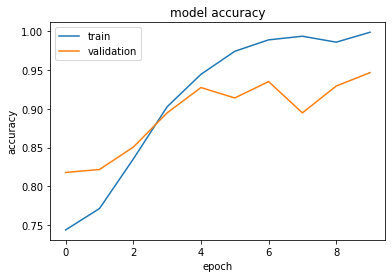

[0.7403068, 0.81359184, 0.89625055, 0.9578185, 0.9729442, 0.9923306, 0.99850875, 1.0, 1.0, 1.0]
[0.7432950139045715, 0.8601532578468323, 0.8544061183929443, 0.9425287246704102, 0.9272030591964722, 0.938697338104248, 0.9425287246704102, 0.9521072506904602, 0.954023003578186, 0.9521072506904602]


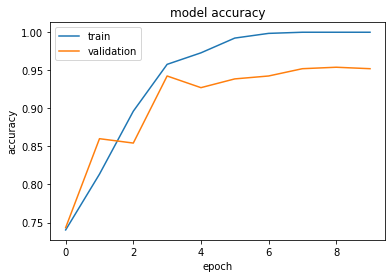

[0.76565826, 0.8749467, 0.9154239, 0.9086067, 0.8749467, 0.89198977, 0.94823176, 0.9735833, 0.988922, 0.98295695]
[0.9042145609855652, 0.8639847040176392, 0.8984674215316772, 0.8812260627746582, 0.8371647596359253, 0.9042145609855652, 0.8888888955116272, 0.8946360349655151, 0.9118773937225342, 0.8984674215316772]


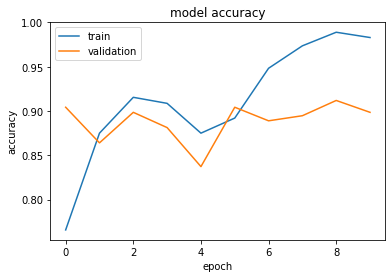

In [18]:

import matplotlib.pyplot as plt
count = 0; 


for i in history_array:
    print(i.history['accuracy'])
    plt.plot(i.history['accuracy'])
    print(i.history['val_accuracy'])
    plt.plot(i.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    name = 'train_vs_validation_accuracy' + str(count) + '.png'
    #plt.savefig('experiment2/'+name)
    plt.show()



# Plot the Model Loss on the Training and Validation

[9.048788983865297, 0.21636926523410974, 0.10677453625072658, 0.07157839887386999, 0.06344399484240303, 0.05583578399110714, 0.034216602491714855, 0.029589721449687727, 0.020948193486800562, 0.01627337675659493]
[0.3853359639187882, 0.10696391404474376, 0.10966650563581236, 0.08569841303994657, 0.14537896227334193, 0.09914509635204556, 0.12564993367826574, 0.13586765345921062, 0.14410653444884838, 0.12394100002823148]


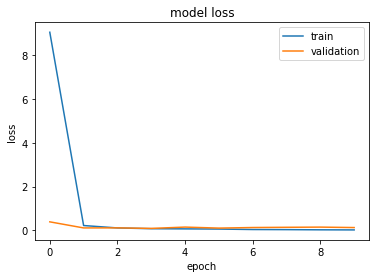

[9.905031820180623, 0.49648577442157, 0.34997942678004973, 0.22992715906172445, 0.18833196259682666, 0.159113524601492, 0.07612596507393328, 0.04955640507280242, 0.023859052547433424, 0.02814911919086259]
[0.4852918110131304, 0.4339339777655985, 0.286044597682825, 0.33311801720624684, 0.3044913759405129, 0.2741235108953326, 0.29532986531084066, 0.2862334540292221, 0.35058008379863137, 0.48439441330131444]


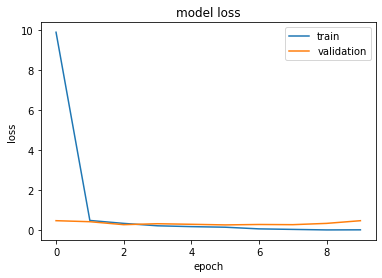

[9.912514237581439, 0.7624475164747665, 0.37276182847171324, 0.24711778843763488, 0.14528056895689706, 0.07934351220034923, 0.03717303843674749, 0.022265174230707483, 0.054034946548455275, 0.006551081538560487]
[0.38650164567647766, 0.41701078631868765, 0.37619108375575805, 0.3423148145849221, 0.2398347534324931, 0.2472917718734321, 0.38564833416335886, 0.34473118337292324, 0.3569616529219909, 0.3796229476672936]


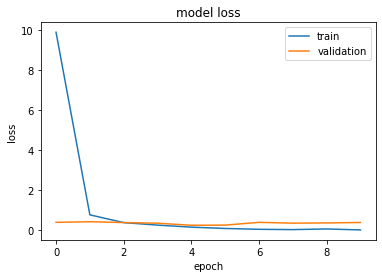

[9.884768539367455, 0.46508894687416097, 0.25119763128951506, 0.11724727636684902, 0.06958117549679459, 0.02417365660649674, 0.008355994952479906, 0.001938221243939878, 0.0007474124996465607, 0.0005067429190856868]
[2.036598226576473, 0.3385859466946445, 0.3042519777670674, 0.16219902392548163, 0.24195565363228091, 0.2109497607439414, 0.2516847013056963, 0.24883733261590715, 0.2660673249270267, 0.2928064550019772]


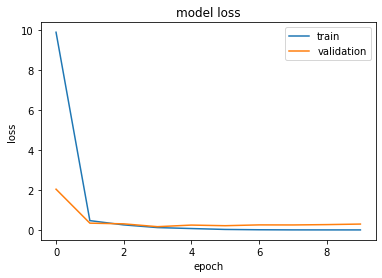

[5.202947077189398, 0.2959537745207789, 0.20047790088270592, 0.23264440575405848, 0.32475462196530513, 0.23259336689608526, 0.1281030941000633, 0.06826250394786425, 0.037543683446361234, 0.049572150332081]
[0.36573818006277997, 0.26637720353758654, 0.3038519954316004, 0.317157302094602, 0.3325207284241344, 0.28741033329589155, 0.3354696350536127, 0.3876895960491736, 0.4413835753426241, 0.5508265406235882]


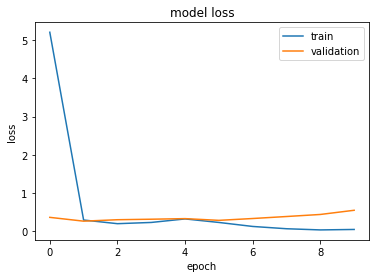

In [19]:
# summarize history for loss

count = 0 
for i in history_array:
    print(i.history['loss'])
    plt.plot(i.history['loss'])
    plt.plot(i.history['val_loss'])
    print(i.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    name = 'train_vs_test_loss_shuffled_btch32_' + str(count) + '.png'
    #plt.savefig(name)
    count = count +1
    plt.show()    
    
  

In [ ]:
# score = model_array[1].evaluate(X_test, y_test_ohe)
# print('Loss ' , score[0])
# print('Test accuracy: ', score[1]*100)

In [20]:
from sklearn.metrics import confusion_matrix
def classification_report():
    
    for i in model_array:
        y_pred = i.predict_classes(X_test)
        matrix = ["TN","FP"],["FN","TP"]
        print(matrix[0])
        print(matrix[1])

        ##Lets Visualise the output
        conf=confusion_matrix(Y_test, y_pred)
        print("Confusion Matrix")
        print(conf)
        # or we can use a heatmap from the seaborn library
        #import seaborn as sn
        #df_cm = pandas.DataFrame(conf, range(2), range(2))
        #sn.set(font_scale=1.4)#for label size
        #sn.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 20},fmt="d")# font size

        from sklearn.metrics import classification_report
        print(classification_report(Y_test,y_pred));
        



In [21]:
accuracy

[[2.0395820606222865, 0.7483974099159241],
 [4.27848080682769, 0.7275640964508057],
 [4.133310873206192, 0.7131410241127014],
 [4.008118573389836, 0.7387820482254028],
 [3.7038744365145013, 0.7339743375778198]]

In [22]:
classification_report()

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[ 80 154]
 [  3 387]]
              precision    recall  f1-score   support

         0.0       0.96      0.34      0.50       234
         1.0       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[ 78 156]
 [ 14 376]]
              precision    recall  f1-score   support

         0.0       0.85      0.33      0.48       234
         1.0       0.71      0.96      0.82       390

    accuracy                           0.73       624
   macro avg       0.78      0.65      0.65       624
weighted avg       0.76      0.73      0.69       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[ 68 166]
 [ 13 377]]
              precision    recall  f1-score   support

         0.0       0.84      0.29      0.43       234
         1.0       0.69      0.97      

## Lets Visualise the output of Confusion Matrix & Classification Report

In [17]:
y_pred = model.predict_classes(X_test)

In [18]:
import matplotlib.pyplot as plt
import pandas
import numpy as np
from sklearn.metrics import confusion_matrix

matrix = ["TN","FP"],["FN","TP"]
print(matrix[0])
print(matrix[1])

conf=confusion_matrix(Y_test, y_pred)
print(conf)

from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))


['TN', 'FP']
['FN', 'TP']
[[ 88 146]
 [ 21 369]]
              precision    recall  f1-score   support

         0.0       0.81      0.38      0.51       234
         1.0       0.72      0.95      0.82       390

    accuracy                           0.73       624
   macro avg       0.76      0.66      0.66       624
weighted avg       0.75      0.73      0.70       624

